Saving istockphoto-1367562233-640_adpp_is.mp4 to istockphoto-1367562233-640_adpp_is (3).mp4
✅ Processing complete! The output video is saved as output.mp4
Displaying sample frames...
Frame 1:


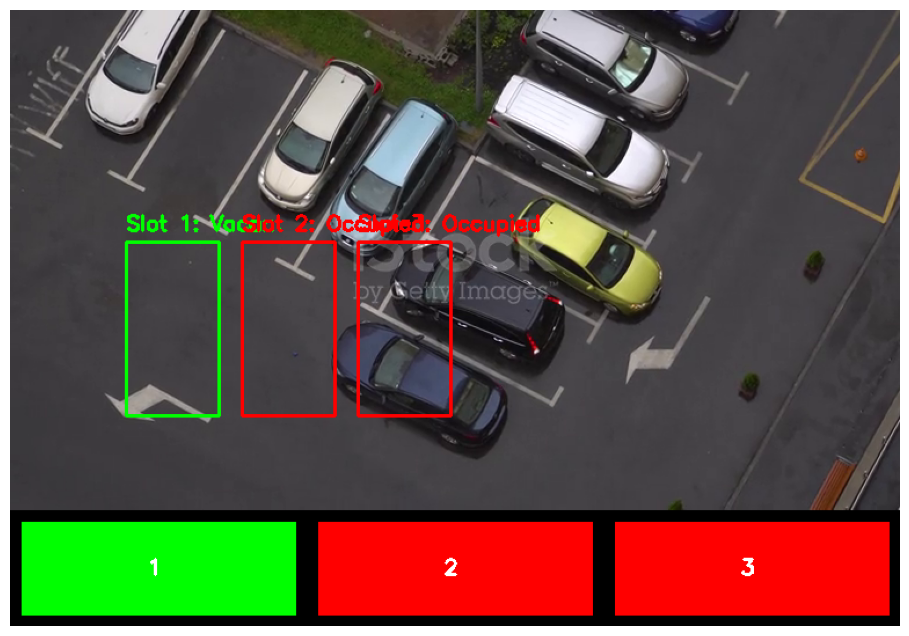

Frame 2:


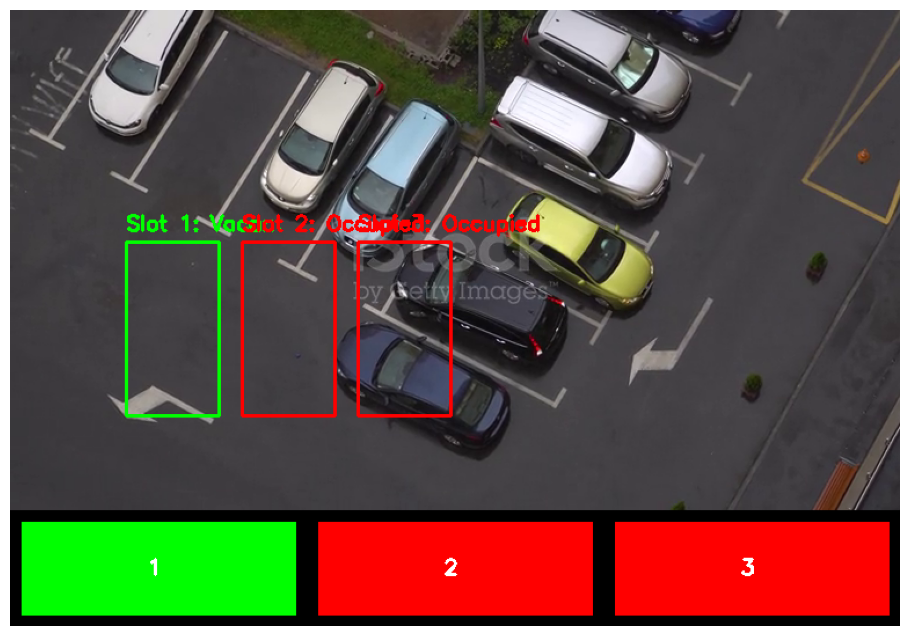

Frame 3:


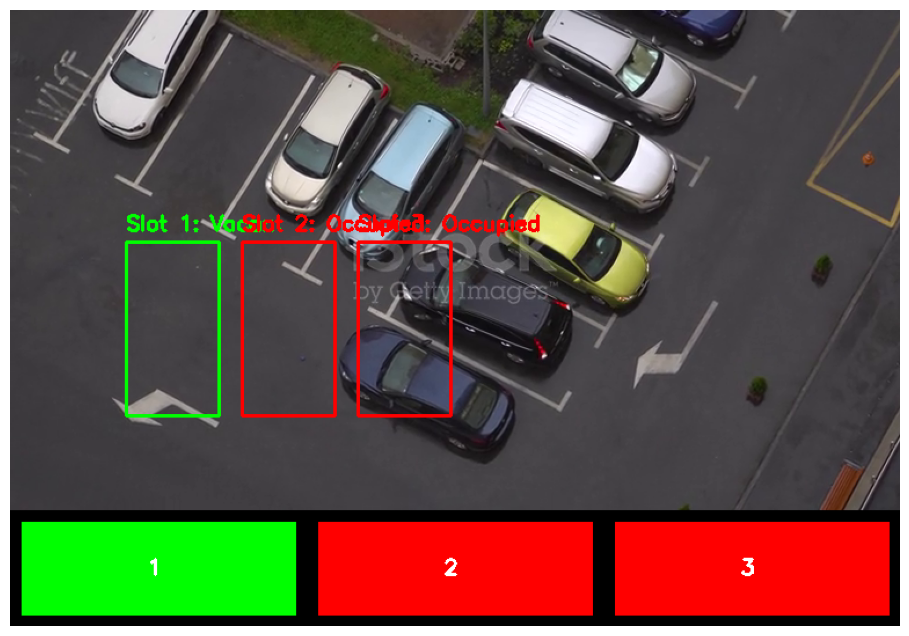

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install dependencies
!pip install ultralytics opencv-python-headless matplotlib -q


# Import libraries
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow  # For displaying images in Colab


# Load YOLOv8 model
model = YOLO("yolov8n.pt")


# Upload/Load Video
from google.colab import files
uploaded = files.upload()  # Upload a video file (e.g., parking.mp4)

video_path = list(uploaded.keys())[0]  # First uploaded file


# Define parking spaces
parking_spaces = [
    (100, 200, 80, 150),
    (200, 200, 80, 150),
    (300, 200, 80, 150)
]


# Process video (Colab compatible)
cap = cv2.VideoCapture(video_path)


# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)


# Define video writer (to save output) - using MP4V codec which works better in Colab
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("output.mp4", fourcc, fps, (width, height))


# Create a summary display panel
summary_height = 100
summary_width = width


# Process the video
frame_count = 0
output_frames = []  # To store frames for display

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    # Process only every nth frame to speed up processing
    if frame_count % 5 != 0:
        continue

    # Create a summary display at the bottom
    summary_display = np.zeros((summary_height, summary_width, 3), dtype=np.uint8)

    # Run YOLOv8 inference
    results = model(frame, verbose=False)
    detections = results[0].boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]

    # Initialize counters
    occupied_count = 0
    vacant_count = 0

    # Check each parking space
    for idx, (x, y, w, h) in enumerate(parking_spaces):
        roi = (x, y, x + w, y + h)
        status = "Vacant"

        # Check overlap with detected cars
        for det in detections:
            x1, y1, x2, y2 = det[:4]
            box = (int(x1), int(y1), int(x2), int(y2))

            # Calculate overlap (intersection area)
            overlap_x1 = max(roi[0], box[0])
            overlap_y1 = max(roi[1], box[1])
            overlap_x2 = min(roi[2], box[2])
            overlap_y2 = min(roi[3], box[3])

            if overlap_x1 < overlap_x2 and overlap_y1 < overlap_y2:
                status = "Occupied"
                break

        # Update counters
        if status == "Occupied":
            occupied_count += 1
        else:
            vacant_count += 1

        # Draw parking slot
        color = (0, 255, 0) if status == "Vacant" else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, f"Slot {idx+1}: {status}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Add summary information to the display
    cv2.putText(summary_display, f"Occupied: {occupied_count}", (50, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv2.putText(summary_display, f"Vacant: {vacant_count}", (50, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Add a visual indicator for each parking space in the summary
    slot_width = summary_width // len(parking_spaces)
    for idx, (x, y, w, h) in enumerate(parking_spaces):
        # Check if this slot is occupied
        status = "Vacant"
        roi = (x, y, x + w, y + h)
        for det in detections:
            x1, y1, x2, y2 = det[:4]
            box = (int(x1), int(y1), int(x2), int(y2))

            overlap_x1 = max(roi[0], box[0])
            overlap_y1 = max(roi[1], box[1])
            overlap_x2 = min(roi[2], box[2])
            overlap_y2 = min(roi[3], box[3])

            if overlap_x1 < overlap_x2 and overlap_y1 < overlap_y2:
                status = "Occupied"
                break

        # Draw the indicator
        color = (0, 255, 0) if status == "Vacant" else (0, 0, 255)
        cv2.rectangle(summary_display,
                     (idx * slot_width + 10, 10),
                     ((idx + 1) * slot_width - 10, 90),
                     color, -1)
        cv2.putText(summary_display, str(idx+1),
                   (idx * slot_width + slot_width//2 - 10, 55),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Combine the frame with the summary display
    combined_frame = np.vstack((frame, summary_display))

    out.write(combined_frame)

    # Store every 30th frame for display
    if frame_count % 30 == 0:
        output_frames.append(combined_frame.copy())

cap.release()
out.release()

print("✅ Processing complete! The output video is saved as output.mp4")


# Display sample frames
print("Displaying sample frames...")
for i, frame in enumerate(output_frames[:3]):  # Show first 3 stored frames
    print(f"Frame {i+1}:")
    # Convert BGR to RGB for matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.show()


# Download output video
from google.colab import files
files.download("output.mp4")